## Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd

# Calendar Information
import datetime
import holidays
import calendar

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Data Preprocessing
from sklearn.preprocessing import FunctionTransformer

# Modeling and Forecasting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Base path for saving plots
base_path_EDA = "/Users/Vageli/Desktop/DABN01/plots/EDA/"

## Load data

### Energy Output

In [3]:
# Load energy output data
output = pd.read_csv(
    '/Users/Vageli/Desktop/DABN01/data/energy_quant_sols1_data/measurements.csv',
    sep=';',
    decimal=','
)

# Set index and name it 'datetime'
output.index = pd.to_datetime(output['Index'], format='%d.%m.%Y %H:%M')
output.index.name = 'datetime'

# Drop the original 'Index' column
output.drop(columns=['Index'], inplace=True)

# Rename the first column to 'output'
output.rename(columns={output.columns[0]: 'output'}, inplace=True)

# Check timezone info
print(output.index.tz)

# Convert to CET and handle DST properly
output_dst = output.tz_localize('CET', ambiguous='infer')


None


### Temperature

In [4]:
# Load temperature data
temperature = pd.read_csv(
    '/Users/Vageli/Desktop/DABN01/data/energy_quant_sols1_data/temperature_stuttgart_h.csv',
    sep=',',
    decimal='.',
    index_col=0,
    parse_dates=True
)

# Rename index and first column
temperature.index.name = 'datetime'
temperature.rename(columns={temperature.columns[0]: 'temperature'}, inplace=True)

# Check timezone info
print(temperature.index.tz)

# Convert to CET
temperature_dst = temperature.tz_convert('CET')

# Upsample to quarter-hourly frequency and forward fill
temperature_dst = temperature_dst.resample('15min').ffill()

UTC+01:00


### Merge Into Single DataFrame

In [5]:
# Merge into a single DataFrame
data = output_dst.join(temperature_dst, how='left')

# Drop NaNs
data = data.dropna()

# Check dates in merged dataset
print(data.index.min())
print(data.index.max())

# Print data length
print(f'Number of observations: {len(data)}')

2020-01-01 00:00:00+01:00
2024-12-16 23:45:00+01:00
Number of observations: 173952


In [6]:
# Show missing values per column
data.info()
data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173952 entries, 2020-01-01 00:00:00+01:00 to 2024-12-16 23:45:00+01:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   output       173952 non-null  float64
 1   temperature  173952 non-null  float64
dtypes: float64(2)
memory usage: 4.0 MB


## Feature Engineering

### General Features

#### Holiday Encoding

In [ ]:
# Create a set of German holidays (province:'BW' for Baden-Württemberg)
de_holidays = holidays.Germany(prov='BW', years=range(data.index.year.min(), data.index.year.max() + 1))

# Encode as 1 if the date is a national holiday
data['is_holiday'] = data.index.map(lambda x: 1 if x.date() in de_holidays else 0)

#### Cyclical Encoding

In [ ]:
# Extract temporal information
data['hour'] = data.index.hour           # 0-23
data['dayofweek'] = data.index.dayofweek  # 0-6
data['month'] = data.index.month          # 1-12

# Define cyclical transformers
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(2 * np.pi * x / period))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(2 * np.pi * x / period))

# Apply cyclical encoding
data['hour_sin'] = sin_transformer(24).fit_transform(data[['hour']])
data['hour_cos'] = cos_transformer(24).fit_transform(data[['hour']])

data['dayofweek_sin'] = sin_transformer(7).fit_transform(data[['dayofweek']])
data['dayofweek_cos'] = cos_transformer(7).fit_transform(data[['dayofweek']])

data['month_sin'] = sin_transformer(12).fit_transform(data[['month']])
data['month_cos'] = cos_transformer(12).fit_transform(data[['month']])

### LightGBM Features

#### Lags of Response Variable

In [ ]:
# Create lag features
data['lag_1w'] = data['output'].shift(672)     # 1 week
data['lag_1m'] = data['output'].shift(2880)    # 1 month
data['lag_1y'] = data['output'].shift(35040)   # 1 year

#### Rolling Windows of Temperature

In [ ]:
# Create rolling window features for temperature
data['temp_roll_mean_1_day'] = data['temperature'].rolling(window=96).mean()
data['temp_roll_mean_7_day'] = data['temperature'].rolling(window=96 * 7).mean()

data['temp_roll_max_1_day'] = data['temperature'].rolling(window=96).max()
data['temp_roll_min_1_day'] = data['temperature'].rolling(window=96).min()

data['temp_roll_max_7_day'] = data['temperature'].rolling(window=96 * 7).max()
data['temp_roll_min_7_day'] = data['temperature'].rolling(window=96 * 7).min()

In [ ]:
# Drop rows with NaNs caused by shifting
data.dropna(inplace=True)

### Data Info

In [ ]:
data.info()

## EDA

### Plots

#### Plot of CHP Production

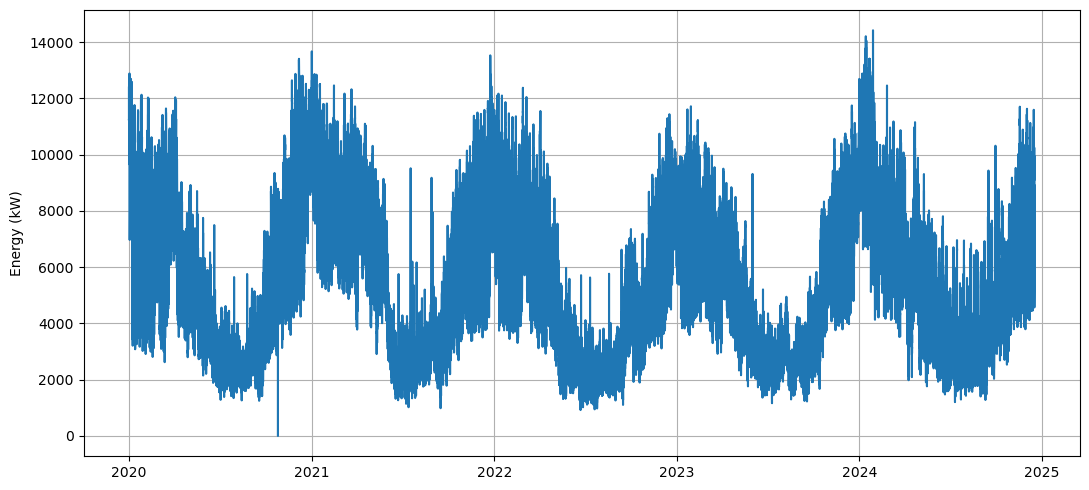

In [7]:
# Saving path
save_path = base_path_EDA + "energy_output.png"

plt.figure(figsize=(11, 5))
plt.plot(data.index, data['output'])
plt.ylabel('Energy (kW)')
plt.grid(True)
plt.tight_layout()
plt.savefig(save_path, dpi=300) # Save to folder
plt.show()

#### Average Quarter-Hourly Output by Day of the Week

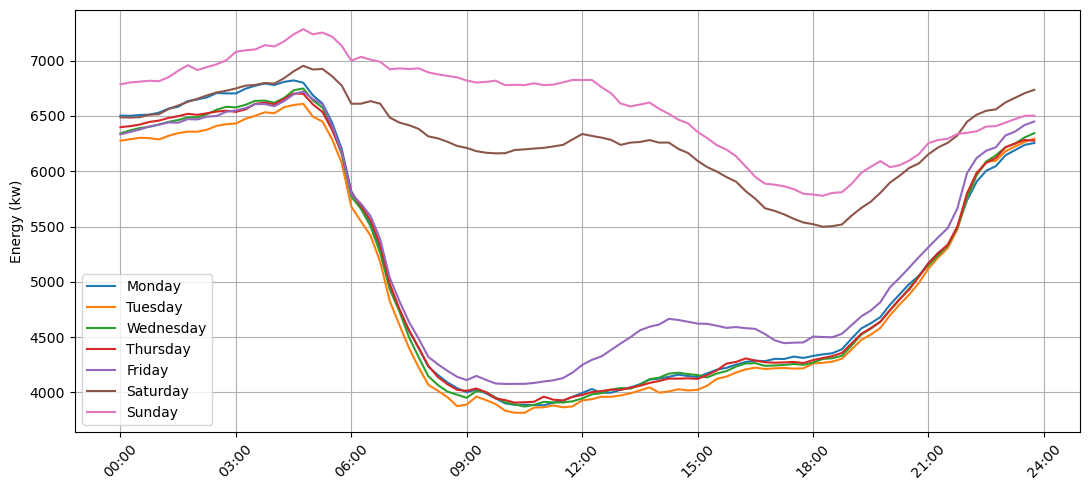

In [8]:
# Saving path
save_path = base_path_EDA + "avg_qh_output_by_dayofweek.png"

# Extract day of week and time of day from the index
day_of_week = data.index.dayofweek
minute_of_day = data.index.hour * 60 + data.index.minute

# Temporary DataFrame using only output
temp_df = pd.DataFrame({
    'output': data['output'],
    'day_of_week': day_of_week,
    'minute_of_day': minute_of_day
})

# Group by time of day and day of week, then average
grouped = temp_df.groupby(['minute_of_day', 'day_of_week']).mean().unstack('day_of_week')

# Plot
plt.figure(figsize=(11, 5))

for i in range(7):
    plt.plot(grouped.index, grouped['output'][i], label=calendar.day_name[i])

plt.ylabel("Energy (kw)")
plt.legend()

# Format x-axis
xticks = np.arange(0, 24 * 60 + 1, 180)  # every 3 hours
xticklabels = [f"{h:02d}:00" for h in range(0, 25, 3)]
plt.xticks(xticks, xticklabels, rotation=45)

plt.grid(True)
plt.tight_layout()

plt.savefig(save_path, dpi=300)

plt.show()

#### Distribution of Energy Output Across Different Months

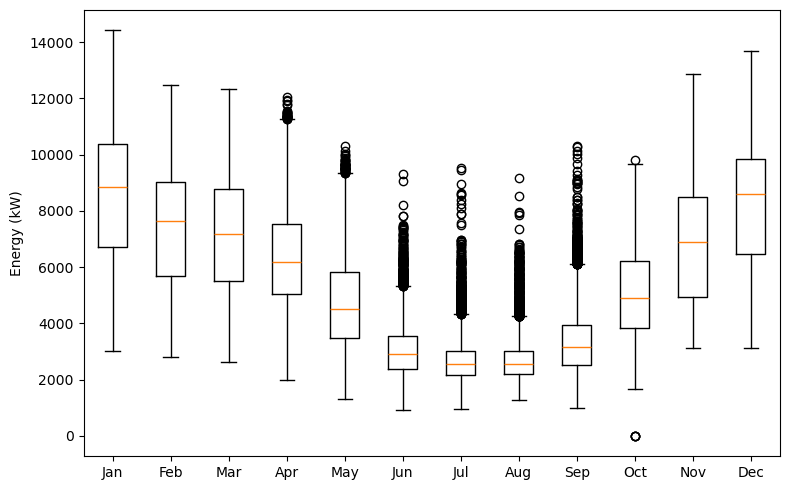

In [9]:
# Saving path
save_path = base_path_EDA + "month_boxplot.png"

# Group output values by month number
monthly_groups = [data['output'][data.index.month == m] for m in range(1, 13)]

# Create the boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(monthly_groups, tick_labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.ylabel('Energy (kW)')
plt.tight_layout()

plt.savefig(save_path, dpi=300)
plt.show()

#### Static Plot of Output and Temperature

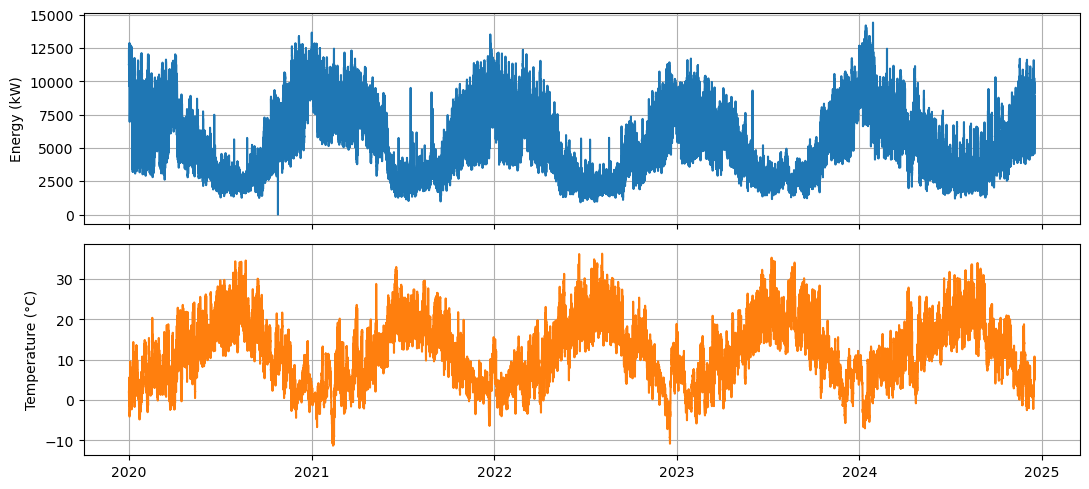

In [10]:
# Saving path
save_path = base_path_EDA + "energy_temperature.png"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5), sharex=True)

# Top plot: Energy Output
ax1.plot(data.index, data['output'], color='tab:blue')
ax1.set_ylabel('Energy (kW)')
ax1.grid(True)

# Bottom plot: Temperature
ax2.plot(data.index, data['temperature'], color='tab:orange')
ax2.set_ylabel('Temperature (°C)')
ax2.grid(True)

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

#### Interactive Plot of Output and Temperature

In [ ]:
# Create the figure with two rows (subplots)
fig = go.Figure()

# Upper plot: Output
fig.add_trace(go.Scatter(
    x=data.index, y=data['output'],
    name='Output',
    yaxis='y1',
    line=dict(color='blue')
))

# Lower plot: Temperature
fig.add_trace(go.Scatter(
    x=data.index, y=data['temperature'],
    name='Temperature',
    yaxis='y2',
    line=dict(color='orange')
))

# Layout with two y-axes stacked vertically
fig.update_layout(
    title='Output and Temperature Over Time',
    xaxis=dict(
        domain=[0, 1],
        rangeslider=dict(visible=True),  # Add scrollable range slider
        title='Datetime'
    ),
    yaxis=dict(
        title='Output',
        side='left',
        anchor='x',
        domain=[0.45, 1.0]  # top half
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        side='left',
        anchor='x',
        domain=[0, 0.4]  # bottom half
    ),
    height=600,
    showlegend=True
)

fig.show()

In [ ]:
# Extract month and minute of day from the index
data['month'] = data.index.month
data['minute_of_day'] = data.index.hour * 60 + data.index.minute

# Group by time of day and month, then calculate average temperature
grouped_temp = data.groupby(['minute_of_day', 'month'])['temperature'].mean().unstack('month')

# Plot
plt.figure(figsize=(12, 6))
for month in range(1, 13):
    plt.plot(grouped_temp.index, grouped_temp[month], label=calendar.month_abbr[month])

plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.title('Average Temperature Profile by Month', fontsize=16)

# Format x-axis to show time in HH:MM
xticks = np.arange(0, 24 * 60 + 1, 180)  # Every 3 hours
xticklabels = [f"{h:02d}:00" for h in range(0, 25, 3)]
plt.xticks(xticks, xticklabels, rotation=45, fontsize=12)

plt.grid(True)
plt.legend(title='Month', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

## Metrics

In [11]:
correlation = data['output'].corr(data['temperature'])
print(f'Correlation between energy output and temperature: {correlation:.3f}')

Correlation between energy output and temperature: -0.769
